In [1]:
# Import necessary modules from main.py and setup
import sys
import os
import torch
from tqdm import tqdm
import json

# Add current directory to path so we can import from main.py
sys.path.append('GRPO_based_soft_thinking')
# Import everything we need from main.py
from evaluator import get_evaluator

from main import (
    parse_args, grpo_loss, 
    generate_completions, score_completions,
    eval_on_test_set
)
import llms
import utils
import evaluator
import rldatasets
from transformers import PreTrainedModel, PreTrainedTokenizerBase, GenerationConfig

print("Successfully imported from main.py!")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")


/mnt/home/adit/mixtureoftokens/vinv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported from main.py!
CUDA available: True
Device count: 1


In [2]:
# Setup arguments (you can modify these as needed)
import argparse

# Create a custom args object with your preferred settings
class Args:
    def __init__(self):
        # Model configuration
        self.model_name = "Qwen/Qwen2.5-1.5B-Instruct"
        self.dataset = "acre.reasoning_gym"
        self.evaluator = "acre.reasoning_gym"
        
        # Output and logging
        self.output_dir = "notebook_output"
        self.verbose = True
        self.save_steps = 50
        self.eval_iterations = 100  # Set high to skip evaluation
        
        # Optimization hyperparameters
        self.learning_rate = 5e-6
        self.adam_beta1 = 0.9
        self.adam_beta2 = 0.99
        self.weight_decay = 0.1
        self.max_grad_norm = 0.1
        self.gradient_accumulation_steps = 4
        self.warmup_percent = 0.18
        self.update_ref_model = True
        self.update_ref_model_freq = 200
        self.ref_model_mixup_alpha = 0.1
        
        # Generation parameters
        self.temperature = 0.9
        self.num_chains = 16  # Smaller for faster experimentation
        self.max_prompt_length = 1000
        self.max_completion_length = 786  # Smaller for faster generation
        
        # Training parameters
        self.num_train_iters = 1000  # Small number for experimentation
        self.kl_weight_beta = 0.1
        self.seed = 7111994
        self.mixture_k = 2
        self.loss_on_all_tokens = 0
        
        # Flash attention parameters
        self.use_flash_attention = 1
        self.system_prompt = """
Think step by step in the following format only:
<think>
</think>
<answer>
</answer>
"""
        self.system_prompt = """
        You will be given a question that involves reasoning. You should reason carefully about the question, then provide your answer.
            It is very important that you put your reasoning process inside <reasoning> tags and your final answer inside <answer> tags, like this:
            <think>
            Your step-by-step reasoning process here
            </think>
            <answer>
            Your final answer here
            </answer>
            All of your returned text should either be in the <reasoning> or <answer> tags - no text outside! Start each answer by immediately starting with <reasoning>. 
            It is is extremely important you answer in this way - do not put any information or text outside of these tags!"""
        
        self.normal_generation = 0  # Use mixture generation
        self.experiment_name = "notebook_experiment"

args = Args()
print("Arguments configured!")
print(f"Model: {args.model_name}")
print(f"Training iterations: {args.num_train_iters}")
print(f"Number of chains: {args.num_chains}")
print(f"Normal generation: {args.normal_generation}")


Arguments configured!
Model: Qwen/Qwen2.5-1.5B-Instruct
Training iterations: 1000
Number of chains: 16
Normal generation: 0


In [3]:
# Initialize everything needed for training
print("Setting up models, datasets, and evaluator...")

# Seed everything 
utils.seed_everything(args.seed)

# Set device and enable bf16
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = True
torch.set_float32_matmul_precision('high') 

print(f"Using device: {device}")

# Load models
print("Loading models...")
model, tokenizer = llms.get_llm_tokenizer(args.model_name, device, use_flash_attention=args.use_flash_attention)
base_model, _ = llms.get_llm_tokenizer(args.model_name, device, use_flash_attention=args.use_flash_attention)

# Load datasets
print("Loading datasets...")
train_loader, test_loader = rldatasets.get_dataloaders(args.dataset)

# Load evaluator
print("Loading evaluator...")
eval_class = evaluator.get_evaluator(args.dataset)

print("✅ Everything loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model device: {next(model.parameters()).device}")


Setting up models, datasets, and evaluator...
Using device: cuda
Loading models...


Loading datasets...


Processing test data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 78933.03it/s]

Loading evaluator...
✅ Everything loaded successfully!
Model parameters: 1,543,714,304
Model device: cuda:0


In [4]:
# Setup optimizer and scheduler
print("Setting up optimizer and scheduler...")

# Setup logging directories
os.makedirs(args.output_dir, exist_ok=True)
train_log_dir = os.path.join(args.output_dir, 'training_logs')
os.makedirs(train_log_dir, exist_ok=True)

# Setup optimizer for trainer agent with GRPO config settings
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.weight_decay,
    eps=1e-8
)

# Add linear warmup learning rate scheduler
warmup_steps = int(args.warmup_percent * args.num_train_iters)
def get_lr(step):
    if step < warmup_steps:
        return (step / warmup_steps)
    return 1.0
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr)

print(f"✅ Optimizer and scheduler ready!")
print(f"Warmup steps: {warmup_steps}")
print(f"Learning rate: {args.learning_rate}")


Setting up optimizer and scheduler...
✅ Optimizer and scheduler ready!
Warmup steps: 180
Learning rate: 5e-06


In [12]:
question = """You are a researcher studying causal relationships using Blicket experiments. In these experiments, certain objects (called 'blickets') have the hidden property of activating a detector, causing its light to turn on.

Each example shows the results of placing different combinations of objects on the detector. Each object is described by color, material and shape. Your task is to determine whether a new combination of objects will cause the detector to activate.

After observing the previous examples and reasoning about them, respond with:
- "on" if you can determine the detector light will turn on
- "off" if you can determine the detector light will stay off
- "undetermined" if there is insufficient evidence to reach a conclusion

Do not use quotation marks in your answer.

Previous experimental results:
yellow metal sphere → on
yellow metal sphere, red rubber sphere → on
red rubber sphere → off
blue rubber cube, green metal sphere, yellow metal cylinder → off
purple rubber cylinder, yellow metal cylinder, green metal sphere, blue rubber cube → on
red rubber cube, green metal sphere → on

New test case:
red rubber cube

What is the detector light status?"""

    
generation_completions = generate_completions(model, tokenizer, question, device, args)

In [13]:
generation_completions[-2]

{'generation_steps': [{'step': 0,
   'chains': [{'chain_id': 0,
     'is_mixture_phase': True,
     'selected_token_id': 28715,
     'selected_token_text': 'Based',
     'is_running': True,
     'top_k_token_ids': [3830, 28715],
     'top_k_token_texts': ['From', 'Based'],
     'top_k_probs': [0.26953125, 0.23828125],
     'normalized_mixture_weights': [0.53125, 0.46875],
     'representative_idx': 1},
    {'chain_id': 1,
     'is_mixture_phase': True,
     'selected_token_id': 3830,
     'selected_token_text': 'From',
     'is_running': True,
     'top_k_token_ids': [3830, 28715],
     'top_k_token_texts': ['From', 'Based'],
     'top_k_probs': [0.26953125, 0.23828125],
     'normalized_mixture_weights': [0.53125, 0.46875],
     'representative_idx': 0},
    {'chain_id': 2,
     'is_mixture_phase': True,
     'selected_token_id': 28715,
     'selected_token_text': 'Based',
     'is_running': True,
     'top_k_token_ids': [3830, 28715],
     'top_k_token_texts': ['From', 'Based'],
    

In [6]:
prompt = [
        {'role': 'system', 'content': args.system_prompt},
        {'role': 'user', 'content': question},
        {'role': 'assistant', 'content': "<think>"},
    ]
prompt_text = tokenizer.apply_chat_template(prompt, add_generation_prompt=False, continue_final_message=True, tokenize=False)

In [7]:
prompt_inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, padding_side="left", add_special_tokens=False)
prompt_ids, prompt_mask = prompt_inputs["input_ids"], prompt_inputs["attention_mask"]
print(prompt_ids.shape)
print(prompt_mask.shape)
# Truncate prompt to max length and repeat for number of generations
prompt_ids = prompt_ids[:, -args.max_prompt_length:]
prompt_mask = prompt_mask[:, -args.max_prompt_length:]
print(prompt_ids.shape)
print(prompt_mask.shape)
# Repeat for number of chains/generations
prompt_ids = prompt_ids.repeat(args.num_chains, 1)
prompt_mask = prompt_mask.repeat(args.num_chains, 1)

# Move tensors to model's device (handles multi-GPU setups)
model_device = next(model.parameters()).device
prompt_ids = prompt_ids.to(model_device)
prompt_mask = prompt_mask.to(model_device)

torch.Size([1, 396])
torch.Size([1, 396])
torch.Size([1, 396])
torch.Size([1, 396])


In [8]:
generation_config = GenerationConfig(
        max_new_tokens=args.max_completion_length,
        do_sample=True, 
        temperature=args.temperature,
        pad_token_id=tokenizer.pad_token_id
    )
prompt_completion_ids = model.generate(prompt_ids,attention_mask=prompt_mask,generation_config=generation_config)

In [11]:
generation_completions[4]

['Based the previous examples, we see observe that objects detector activates turns on when a red rubber cube is combined with it. The other objects either turn on the detector or turn it off. Since, we on this pattern observed, the new test case with a red rubber cube should also cause the detector to to turn on.</think>\n\n<answer>\non</answer>',
 'From the previous examples, we can observe that objects detector light turns on when there yellow rubber cube is combined on it. The other combinations either turn on or detector or do it off. Since, we on the pattern observed in we new test case with a red rubber cube should also cause the detector to to turn on.</think><answer>\non</answer>',
 'From the previous examples, we can see that the detector activates turns on when there red rubber cube is placed with it. This other combinations did turn on or detector or turn it off, Since, we on the previous,, the new test case of a red rubber cube should also cause the detector light to turn 

In [ ]:
# Training loop WITHOUT evaluation (so you can experiment freely!)
print("🚀 Starting training loop...")
print("=" * 50)

# Initialize tracking variables
accumulated_loss = 0
optimizer.zero_grad()
train_metrics_total = {}

# Main training loop
for round_num in tqdm(range(args.num_train_iters), desc="Training Progress"):
    
    # Update reference model periodically
    if args.update_ref_model and (round_num+1) % args.update_ref_model_freq == 0:
        with torch.no_grad():
            for param, ref_param in zip(model.parameters(), base_model.parameters()):
                ref_param.data = args.ref_model_mixup_alpha * param.data + (1 - args.ref_model_mixup_alpha) * ref_param.data
        if args.verbose:
            print(f"\n📝 Updated reference model at step {round_num}")

    # Get next training example
    try:
        question, answer = next(train_loader)
    except StopIteration:
        print("\n🔄 Reached end of training set. Restarting from beginning.")
        train_loader.reset()
        question, answer = next(train_loader)

    # Compute GRPO loss
    total_loss, train_metrics = grpo_loss(
        model, base_model, tokenizer, question, answer, 
        eval_class, device, round_num, train_log_dir, args
    )
    
    # Gradient accumulation
    total_loss.backward()
    accumulated_loss += total_loss.item()
    scheduler.step()

    # Step optimizer
    if (round_num + 1) % args.gradient_accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()    

    # Log metrics
    train_metrics["learning_rate"] = scheduler.get_last_lr()[0]
    train_metrics["loss"] = total_loss.item() * args.gradient_accumulation_steps
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), float('inf')).item()
    train_metrics["grad_norm"] = grad_norm
    train_metrics_total[round_num] = train_metrics
    
    # Print progress every 10 steps
    if (round_num + 1) % 100 == 0:
        print(f"\n📊 Step {round_num+1}/{args.num_train_iters}")
        print(f"   Loss: {train_metrics['loss']:.4f}")
        print(f"   LR: {train_metrics['learning_rate']:.2e}")
        print(f"   Reward: {train_metrics.get('reward', 0):.3f}")
        print(f"   KL: {train_metrics.get('kl', 0):.4f}")
    if (round_num) % args.eval_iterations == 0:
        eval_metrics, eval_accuracy = eval_on_test_set(
            model=model,
            tokenizer=tokenizer, 
            test_loader=test_loader,
            eval_class=eval_class,
            device=device,
            args=args,
            round_num=round_num
        )
        print(f"Eval metrics: {eval_metrics}")
        print(f"Eval accuracy: {eval_accuracy}")
    if round_num==300:
        break


print("\n🎉 Training completed!")
print(f"Final loss: {train_metrics.get('loss', 0):.4f}")
print(f"Logs saved to: {train_log_dir}")


In [ ]:
question, answer = next(train_loader)

In [1]:
import pandas as pd
import json as json

In [45]:
import numpy as np
import matplotlib.pyplot as plt
    
def return_plot(exp_name,round_no):
    num_rounds = len(round_no)
    fig, axs = plt.subplots(2,1)
    for round_no in round_no:
        with open(f'GRPO_based_soft_thinking/output/{exp_name}/training_logs/{round_no}_detailed_generation.json', 'r') as f:
            data = f.read()
            data = json.loads(data)
        tokens_lens = []
        entropies = np.zeros((100,8)) 
        for round_num in range(100):
            tokens = []
            for chain_id in range(8):
                
                if 'is_mixture_phase' in data['generation_steps'][round_num]['chains'][chain_id]:
                    if data['generation_steps'][round_num]['chains'][chain_id]['is_mixture_phase']:
                        tokens_step = np.array(data['generation_steps'][round_num]['chains'][chain_id]['top_k_token_ids'])
                        probs_step = np.array(data['generation_steps'][round_num]['chains'][chain_id]['top_k_probs'])
                        high_prob_tokens = list(tokens_step[probs_step>0.1])
                        tokens+=high_prob_tokens
                        entropies[round_num,chain_id] = -np.sum(probs_step * np.log(probs_step))
            tokens_lens.append(len(set(tokens)))
        axs[0].plot(tokens_lens,label=f'Round {round_no}')
        axs[1].plot(entropies.mean(axis=1),label=f'Round {round_no}')
    axs[0].legend()
    axs[1].legend()
    plt.show()
    
    

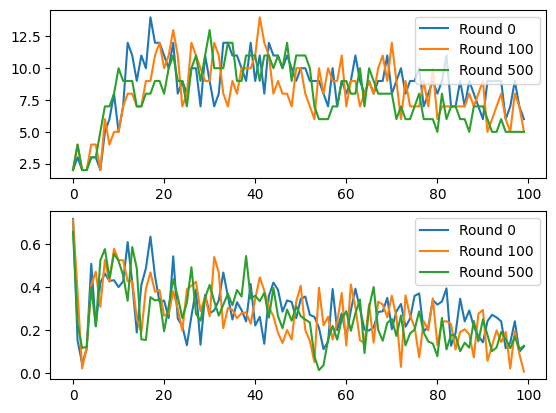

In [50]:
return_plot('mixture_grpo_acre.reasoning_gym_1.5b_llmjudge_dirichlet_1000_steps_max_token_eval_50_prompt_big_2',[0,100,500])

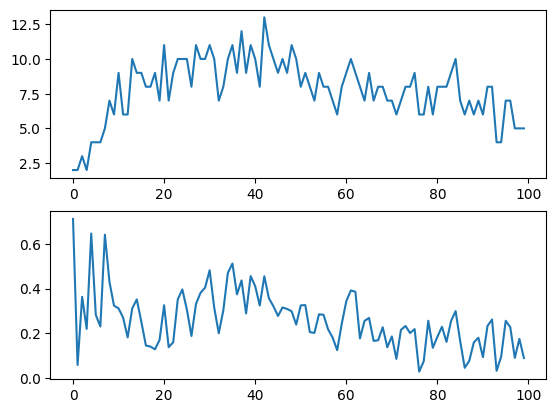

In [40]:
return_plot('mixture_grpo_acre.reasoning_gym_1.5b_llmjudge_dirichlet_1000_steps_max_token_eval_50_prompt_big_2',300)